In [1]:
import os
import numpy as np
import torch
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import flow_vis

%matplotlib inline

In [2]:
# you can modify the absolute path of dtu dataset with your own one
dtu_data_path = "/home/xhb/datasets/mvsnet_data/training_data/dtu_training"

In [3]:
# select a scan for testing
test_scan = "scan11"

image_dir = os.path.join(dtu_data_path, "Rectified", "{}_train".format(test_scan))
cam_dir = os.path.join(dtu_data_path, "Cameras")
depth_dir = os.path.join(dtu_data_path, "Depths", "{}_train".format(test_scan))

In [4]:
def read_cam_file(filename):
    with open(filename) as f:
        lines = f.readlines()
        lines = [line.rstrip() for line in lines]
    # extrinsics: line [1,5), 4x4 matrix
    extrinsics = np.fromstring(' '.join(lines[1:5]), dtype=np.float32, sep=' ').reshape((4, 4))
    # intrinsics: line [7-10), 3x3 matrix
    intrinsics = np.fromstring(' '.join(lines[7:10]), dtype=np.float32, sep=' ').reshape((3, 3))
    # depth_min & depth_interval: line 11
    depth_min = float(lines[11].split()[0])
    depth_interval = float(lines[11].split()[1])
    return intrinsics, extrinsics, depth_min, depth_interval

In [5]:
import numpy as np
import re

def read_pfm(filename):
    file = open(filename, 'rb')
    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().decode('utf-8').rstrip()
    if header == 'PF':
        color = True
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('utf-8'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0:  # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>'  # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    file.close()
    return data, scale

In [6]:
# load data of the whole scene

# image
images = []
for v in range(49):
    image_path = os.path.join(image_dir, "rect_{:03d}_3_r5000.png".format(v+1))
    image = Image.open(image_path)
    image = np.array(image)
#     print("image: {}".format(image.shape))
    images.append(image)
    
# cam
cam_ints = []
cam_exts = []
for v in range(49):
    cam_path = os.path.join(cam_dir, "train", "{:08d}_cam.txt".format(v))
    intrinsics, extrinsics, depth_min, depth_interval = read_cam_file(cam_path)
    intrinsics[:2, :] *= 4  # rescale the intrinsic matrix to match the exact resolution of original image
#     print("intrinsics: {}".format(intrinsics))
    cam_ints.append(intrinsics)
    cam_exts.append(extrinsics)
    
# depth
depths = []
masks = []
for v in range(49):
    depth_path = os.path.join(depth_dir, "depth_map_{:04d}.pfm".format(v))
    depth = np.array(read_pfm(depth_path)[0], dtype=np.float32)
    depths.append(depth)
    
    mask_path = os.path.join(depth_dir, "depth_visual_{:04d}.png".format(v))
    mask = Image.open(mask_path)
    mask = np.array(mask, dtype=np.float32)
    mask = (mask > 10).astype(np.float32)
#     mask = cv2.resize(mask, (640, 512), interpolation=cv2.INTER_NEAREST)
    masks.append(mask)
#     print("mask: {}".format(mask.shape))

In [7]:
def depth_pose2flow(depth, ref_in, ref_ex, src_in, src_ex):
    """
    :param depth:    B x H x W
    :param ref_in:   B x 3 x 3
    :param ref_ex:   B x 4 x 4
    :param src_in:   B x 3 x 3
    :param src_ex:   B x 4 x 4
    :return:         B x 2 x H x W
    """
    batch = depth.shape[0]
    height, width = depth.shape[1], depth.shape[2]

    src_proj = torch.matmul(src_in, src_ex[:, 0:3, :])  # B x 3 x 4
    ref_proj = torch.matmul(ref_in, ref_ex[:, 0:3, :])  # B x 3 x 4
    last = torch.tensor([[[0, 0, 0, 1.0]]]).repeat(len(src_in), 1, 1).to(depth.device)
    src_proj = torch.cat((src_proj, last), 1)  # B x 4 x 4
    ref_proj = torch.cat((ref_proj, last), 1)  # B x 4 x 4
    proj = torch.matmul(src_proj, torch.inverse(ref_proj))
    rot = proj[:, :3, :3]  # [B,3,3]
    trans = proj[:, :3, 3:4]  # [B,3,1]

    y, x = torch.meshgrid([torch.arange(0, height, dtype=torch.float32, device=depth.device),
                           torch.arange(0, width, dtype=torch.float32, device=depth.device)])
    y, x = y.contiguous(), x.contiguous()
    y, x = y.view(height * width), x.view(height * width)
    grid = torch.stack((x, y))  # [2, H*W]
    xyz = torch.stack((x, y, torch.ones_like(x)))  # [3, H*W]
    xyz = torch.unsqueeze(xyz, 0).repeat(batch, 1, 1)  # [B, 3, H*W]
    rot_xyz = torch.matmul(rot, xyz)  # [B, 3, H*W]
    d = depth.reshape(batch, height * width).unsqueeze(1)  # [B, 1, H*W]
    rot_depth_xyz = rot_xyz * d  # [B, 3, H*W]
    proj_xyz = rot_depth_xyz + trans  # [B, 3, H*W]
    proj_xy = proj_xyz[:, :2, :] / proj_xyz[:, 2:3, :].clamp(min=1e-3)  # [B, 2, H*W]
    flow = proj_xy - grid.unsqueeze(0)  # [B, 2, H*W]
    return flow.reshape(batch, 2, height, width)

In [16]:
ref_view = 0
src_view = 5

# convert numpy arrays to tensor
ref_int = torch.Tensor(cam_ints[ref_view]).unsqueeze(dim=0)
src_int = torch.Tensor(cam_ints[src_view]).unsqueeze(dim=0)
ref_ext = torch.Tensor(cam_exts[ref_view]).unsqueeze(dim=0)
src_ext = torch.Tensor(cam_exts[src_view]).unsqueeze(dim=0)
ref_depth = torch.Tensor(depths[ref_view]).unsqueeze(dim=0)
ref_mask = torch.Tensor(masks[ref_view]).unsqueeze(dim=0)
print("ref_int: {}".format(ref_int.shape))
print("src_int: {}".format(src_int.shape))
print("ref_ext: {}".format(ref_ext.shape))
print("src_ext: {}".format(src_ext.shape))
print("ref_depth: {}".format(ref_depth.shape))
print("ref_mask: {}".format(ref_mask.shape))

ref2src_flow = depth_pose2flow(ref_depth * ref_mask, ref_int, ref_ext, src_int, src_ext)
print("ref2src_flow: {}".format(ref2src_flow.shape))

# convert back to numpy
ref2src_flow = ref2src_flow * ref_mask.unsqueeze(dim=1)
ref2src_flow = ref2src_flow.squeeze(dim=0).permute(1, 2, 0).cpu().numpy()
flow_viz = flow_vis.flow_to_color(ref2src_flow, convert_to_bgr=False)

ref_int: torch.Size([1, 3, 3])
src_int: torch.Size([1, 3, 3])
ref_ext: torch.Size([1, 4, 4])
src_ext: torch.Size([1, 4, 4])
ref_depth: torch.Size([1, 128, 160])
ref_mask: torch.Size([1, 128, 160])
ref2src_flow: torch.Size([1, 2, 128, 160])


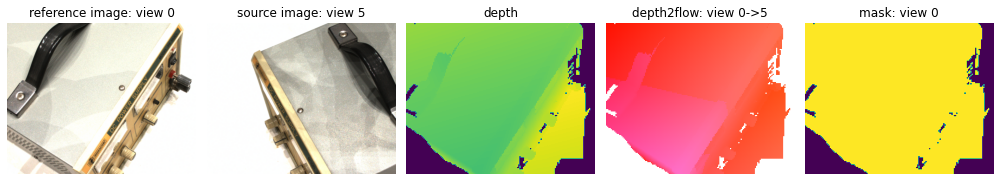

In [17]:
# visualization
ref_img = images[ref_view]
src_img = images[src_view]
ref_dep = depths[ref_view]
ref_mask = masks[ref_view]
plt.figure(figsize=(14, 6))
plt.subplot(1, 5, 1)
plt.imshow(ref_img)
plt.title('reference image: view {}'.format(ref_view))
plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(src_img)
plt.title('source image: view {}'.format(src_view))
plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(ref_dep)
plt.title('depth')
plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(flow_viz)
plt.title('depth2flow: view {}->{}'.format(ref_view, src_view))
plt.axis('off')
plt.subplot(1, 5, 5)
plt.imshow(ref_mask)
plt.title('mask: view {}'.format(ref_view))
plt.axis('off')

plt.tight_layout()
plt.show()